In [1]:
from pathlib import Path

import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
import einops

from dataclasses import dataclass
from typing import Iterable
import xarray as xr
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from itertools import chain

from nowcasting_dataloader.data_sources.satellite.satellite_model import SAT_MEAN, SAT_STD

In [2]:
DATA_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15")

SATELLITE_CHANNELS = (
    "IR_016",
    "IR_039",
    "IR_087",
    "IR_097",
    "IR_108",
    "IR_120",
    "IR_134",
    "VIS006",
    "VIS008",
    "WV_062",
    "WV_073",
)

In [3]:
def satellite_normalisation_stats_to_data_array(stat: dict) -> xr.DataArray:
    return xr.DataArray(
        [stat[chan_name] for chan_name in SATELLITE_CHANNELS],
        dims="channels_index",
    ).astype(np.float32)

SAT_MEAN = satellite_normalisation_stats_to_data_array(SAT_MEAN)
SAT_STD = satellite_normalisation_stats_to_data_array(SAT_STD)

In [4]:
def align_time(src: xr.Dataset, dst: xr.Dataset) -> xr.DataArray:
    """Align `dst` to have the same `time` coords as `src.time`.
    
    For example, use this to ensure that batch['opticalflow'] has the same
    time coords as batch['gsp'].
    """
    # I tried a bunch of "vectorised" ways of doing this.  This appears to be the
    # only way of doing it.  The issue is that each example ends up having different
    # time_index coords so, in order to align, we must reset the "time_index" of each example.
    # We take the satellite image _15 minutes_ before the GSP data, because the GSP data is
    # the average power for the half-hour-ending.
    time_index = src.time - pd.Timedelta("15 minutes")
    n_timesteps = src.time.shape[1]
    time_index_bool_mask = dst.time.isin(time_index)
    data_arrays_for_examples = []
    n_examples = len(time_index_bool_mask)
    for example_i in range(n_examples):
        selection = dst["data"].isel(example=example_i, time_index=time_index_bool_mask[example_i])
        # Ensure there are never too many timesteps
        selection = selection.isel(time_index=slice(None, n_timesteps))
        selection.__setitem__("time_index", np.arange(len(selection["time_index"])))
        data_arrays_for_examples.append(selection)
        
    new_dst = xr.concat(data_arrays_for_examples, dim="example")
    return new_dst

In [5]:
N_DATETIME_FEATURES = 4  # sin & cos for time of day and day of year


def create_datetime_features(t0_datetimes: np.ndarray) -> dict[str, np.ndarray]:
    t0_datetimes = pd.DatetimeIndex(t0_datetimes)
    n_examples = len(t0_datetimes)

    datetime_features = np.full(shape=(n_examples, N_DATETIME_FEATURES), fill_value=np.NaN, dtype=np.float32)

    hour_of_day = t0_datetimes.hour + (t0_datetimes.minute / 60)
    day_of_year = t0_datetimes.day_of_year + (hour_of_day / 24)

    hour_of_day_radians = (hour_of_day / 24.0) * 2 * np.pi
    day_of_year_radians = (day_of_year / 366 ) * 2 * np.pi  #  366 for leap years!

    datetime_features[:, 0] = np.sin(hour_of_day_radians)
    datetime_features[:, 1] = np.cos(hour_of_day_radians)
    datetime_features[:, 2] = np.sin(day_of_year_radians)
    datetime_features[:, 3] = np.cos(day_of_year_radians)
    
    return {
        "datetime_features": datetime_features,
        "hour_of_day": hour_of_day.values,
        "day_of_year": day_of_year.values,
        "month": t0_datetimes.month.values
    }

In [6]:
@dataclass
class SimpleNowcastingDataset(data.Dataset):
    """
    Attributes:
        data_path: Base path to the pre-prepared dataset.  e.g. .../v15/train/
        data_source_names: The names of the data sources.  Must also be the names of the subdirectory.  
            Must include "gsp".
        gsp_first_time_index_of_future: The index into the GSP time_index dimension that marks the start of the "future".
        n_batches: The number of available batches.
    """
    data_path: Path
    data_source_names: Iterable[str]
    gsp_first_time_index_of_future: int = 2
    
    def __post_init__(self):
        # Sanity checks
        assert self.data_path.exists()
        assert len(self.data_source_names) > 0
        assert "gsp" in self.data_source_names
        self.n_batches = self._get_number_of_batches()
        
    def _get_number_of_batches(self) -> int:
        """Get number of batches.  Check every data source."""
        n_batches = None
        for data_source_name in self.data_source_names:
            path_for_data_source = self.data_path / data_source_name
            n_batches_for_data_source = len(list(path_for_data_source.glob("*.nc")))
            if n_batches is None:
                n_batches = n_batches_for_data_source
            else:
                assert n_batches == n_batches_for_data_source
        assert n_batches is not None
        assert n_batches > 0
        return n_batches
    
    def __len__(self) -> int:
        return self.n_batches
    
    def __getitem__(self, idx: int):
        """
        Returned shapes:
            gsp: batch_size, n_timesteps
            opticalflow: "example", "time_index", "channels_index",  "y_index", "x_index"
        """
        data_from_all_sources = {}
        # Parallelising this with concurrent.futures.ThreadPoolExecutor actually
        # appears to be _slower_ than the simple loop approach!
        for data_source_name in self.data_source_names:
            filename = self.data_path / data_source_name / f"{idx:06d}.nc"
            dataset = xr.open_dataset(filename)
            
            # Select just the "future" timesteps at half-hour intervals (t1, t2, etc.)
            # for the first GSP (the "target").
            if data_source_name == "gsp":
                dataset = dataset.isel(
                    time_index=slice(self.gsp_first_time_index_of_future, None),
                    id_index=0
                ).load()
                # Normalise GSP
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
                dataset["data"] = dataset["data"].astype(np.float32)
                
                # Datetime features
                t0_datetimes = dataset.time.values[:, 0]
                
            if data_source_name == "pv":
                try:
                    dataset = dataset.isel(time_index=slice(None, 7))
                except ValueError as e:
                    print(f"Exception raised when reading PV: {filename}", flush=True)
                    raise
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
            
            if data_source_name in ["satellite", "opticalflow"]:
                # Normalise satellite and opticalflow
                dataset["data"] = dataset["data"].astype(np.float32)
                dataset["data"] -= SAT_MEAN
                dataset["data"] /= SAT_STD
                dataset["data"] = dataset["data"].transpose("example", "time_index", "channels_index", "y_index", "x_index")

            data_from_all_sources[data_source_name] = dataset

        if ("satellite" in self.data_source_names) and ("opticalflow" in self.data_source_names):
            # Concatenate half an hour of satellite data to the start of the opticalflow data
            # so we can use imagery 15 minutes before the GSP timestep, because the GSP data
            # is half-hour-ending.
            data_from_all_sources["opticalflow"] = xr.concat(
                (
                    data_from_all_sources["satellite"].isel(time_index=slice(None, 7)),
                    data_from_all_sources["opticalflow"]
                ),
                dim="time_index",
            )
            
        # Conform all other data sources to have the same time index as GSP
        for data_source_name in self.data_source_names:
            if data_source_name not in ["gsp", "pv"]:
                data_from_all_sources[data_source_name] = align_time(
                    src=data_from_all_sources["gsp"],
                    dst=data_from_all_sources[data_source_name].load())
                
        # Strip away everything that's not required by the PyTorch model
        if ("satellite" in data_from_all_sources) and ("opticalflow" in data_from_all_sources):
            del data_from_all_sources["satellite"]
                
        # Select just the data.  Grab other useful DataArrays.
        for data_source_name in self.data_source_names:
            data = data_from_all_sources[data_source_name]
            if data_source_name == "gsp":
                data_from_all_sources["gsp_id"] = torch.from_numpy(data["id"].values.astype(np.int32))
                data = data["data"]
                
            if data_source_name == "pv":
                data_from_all_sources["pv_system_id"] = torch.from_numpy(data["id"].values.astype(np.float32))
                data_from_all_sources["pv_x_coords"] = torch.from_numpy(data["x_coords"].values.astype(np.float32))
                data_from_all_sources["pv_y_coords"] = torch.from_numpy(data["y_coords"].values.astype(np.float32))
                data = data["data"]
                
            data_from_all_sources[data_source_name] = torch.from_numpy(data.values)
            
        # Datetime features.
        datetime_features = create_datetime_features(t0_datetimes)
        for feature_name, feature_values in datetime_features.items():
            data_from_all_sources[feature_name] = torch.from_numpy(feature_values)
        
        # Check for NaNs
        for data_source_name, data in data_from_all_sources.items():
            if not data_source_name.startswith("pv") and np.isnan(data).any():
                raise RuntimeError(f"NaNs in {data_source_name} batch {idx}")

        return data_from_all_sources

In [7]:
train_dataset = SimpleNowcastingDataset(
    data_path=DATA_PATH / "train",
    data_source_names=("gsp", "satellite", "pv"),
)

In [8]:
len(train_dataset)

8400

In [9]:
%%time
batch = train_dataset[8]

CPU times: user 234 ms, sys: 9.76 ms, total: 244 ms
Wall time: 241 ms


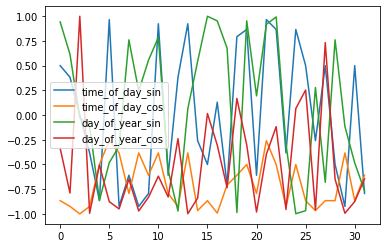

In [28]:
fig, ax = plt.subplots()
ax.plot(batch["datetime_features"], label=['time_of_day_sin', 'time_of_day_cos', 'day_of_year_sin', 'day_of_year_cos'])
ax.legend();

In [36]:
batch["pv"].nanmean(dim=2).shape

torch.Size([32, 7])

In [29]:
# shape: batch, timestep, pv system
batch["pv"].isnan().shape

torch.Size([32, 7, 128])

In [53]:
batch["pv"].isnan().any(dim=1).shape

torch.Size([32, 128])

128

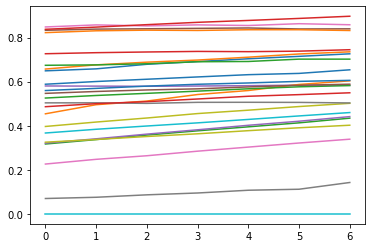

In [29]:
len(plt.plot(batch["pv"][0]))

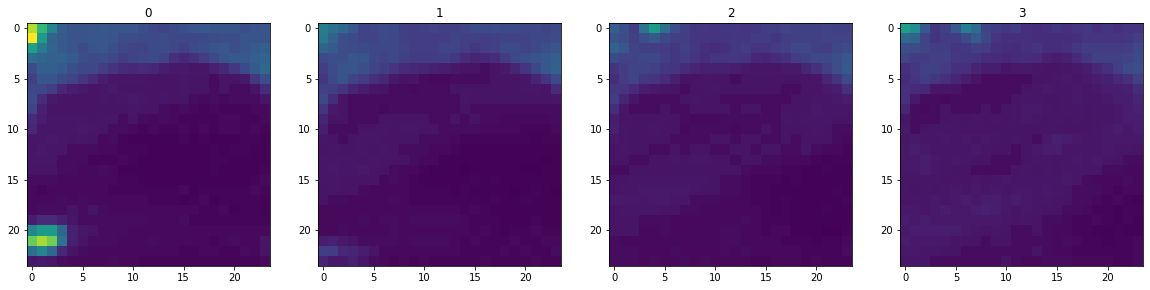

In [14]:
def plot_imagery(tensor, example_i, channel_i):
    fig, axes = plt.subplots(ncols=4, figsize=(20, 10))
    # axes = list(chain.from_iterable(axes))
    # "example", "time_index", "channels_index", "y_index", "x_index"
    data_to_plot = tensor[example_i, :4, channel_i, :, :]
    vmin = data_to_plot.min()
    vmax = data_to_plot.max()
    for time_index, ax in enumerate(axes):
        ax.imshow(data_to_plot[time_index].numpy()[::-1], vmin=vmin, vmax=vmax)
        ax.set_title(time_index)
    return fig, axes

EXAMPLE_I = 5
CHANNEL_I = 7
plot_imagery(batch["satellite"], example_i=EXAMPLE_I, channel_i=CHANNEL_I);

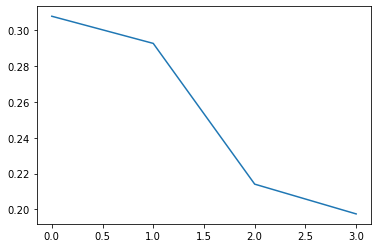

In [15]:
plt.plot(batch["gsp"][EXAMPLE_I]);

## Put the dataset into a DataLoader

In [9]:
dataloader_kwargs = dict(
    batch_size=None,
    num_workers=12,
    pin_memory=True,
)

In [10]:
train_dataloader = data.DataLoader(
    train_dataset,
    **dataloader_kwargs
)

In [11]:
test_dataloader = data.DataLoader(
    SimpleNowcastingDataset(
        data_path=DATA_PATH / "test",
        data_source_names=("gsp", "satellite", "pv"),
    ),
    **dataloader_kwargs
)

In [12]:
%%time
for batch in train_dataloader:
    break

CPU times: user 2.08 s, sys: 4.64 s, total: 6.72 s
Wall time: 8.05 s


# Define the ML model

Each input "row" to the Perceiver will look like this:

Shape: batch_size, seq_len, embedding_dim

Try to keep the constant-length things in the same position.  e.g. the modality embedding always comes first.  The position encoding always comes second (for modalities which have spatial positions).

* Opticalflow: (just one channel at a time)
    - learnt modality embedding (4)
    - relative x and y position encoding (16)
    - 4x4 patch of pixel values (16)
    - learnt channel embedding (4)
* PV:
    - learnt modality embedding (4)
    - relative x and y position encoding (16)
    - entire historical timeseries for one PV system (7)
    - learnt PV ID embedding (13)
* Datetime:
    - learnt modality embedding (4)
    - all timesteps for forecast (4) x 9 features
* The learnt "query" to the Perceiver:
    - Embedding of the GSP ID?  Or different learnable params, one for each GSP ID?  Or just a single learnt number?
* GSP ID & area
    - area
    - embedding of GSP ID
    - learnt modality identifier

In [13]:
import math

In [14]:
def position_encoding(n_encoding_channels: int, seq_length: int = 24, period: float = 5.0) -> torch.Tensor:
    """
    Args:
       n_encoding_channels: The number of "waves" in the encoding.
       seq_length: The sequence length.
       period: A rough specification for the period.  The larger the number, 
           the longer the period of the longest sin and cos waves.
           
    Returns:
        Tensor of shape (seq_length, n_encoding_channels)
    Adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    position = torch.arange(seq_length).unsqueeze(1) * 2
    div_term = torch.exp(torch.arange(0, n_encoding_channels, 2) * (-math.log(period) / n_encoding_channels))
    pe = torch.empty(seq_length, n_encoding_channels)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [15]:
%%time
pe = position_encoding(n_encoding_channels=8, seq_length=6, period=3)

CPU times: user 0 ns, sys: 3.22 ms, total: 3.22 ms
Wall time: 11.4 ms


In [16]:
pe.shape

torch.Size([6, 8])

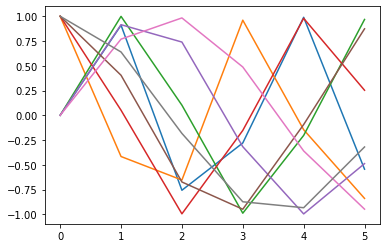

In [17]:
plt.plot(pe);

In [18]:
def plot_timeseries(actual: torch.Tensor, predicted: torch.Tensor) -> plt.Figure:
    predicted = predicted.squeeze()
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 20))
    axes = list(chain.from_iterable(axes))
    for example_i, ax in enumerate(axes):
        ax.plot(predicted[example_i].detach().cpu(), label="predicted")
        ax.plot(actual[example_i].detach().cpu(), label="actual")
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{(int(x)+1)*30:d} min"))
        ax.set_ylim(0, 1)
        ax.legend()
    return fig

In [19]:
N_GSPs = 350

class Model(pl.LightningModule):
    def __init__(
        self, 
        embed_dim_query: int = 128,  # TODO: Play with this number
        num_elements_query: int = 32,
        num_heads: int = 16,
        num_latent_transformer_encoder_layers: int = 4,
        dropout: float = 0.0,
        byte_array_dim: int = 40,  # The dimensionality of each key & value element.
        gsp_id_embedding_dim: int = 16,
    ):
        super().__init__()
        self.embed_dim_query = embed_dim_query
        self.num_elements_query = num_elements_query
        
        # Create position encoding vectors
        self.register_buffer(
            "position_encoding", 
            position_encoding(n_encoding_channels=8, seq_length=6, period=3))
        
        # PERCEIVER #################################
        # Layers for the Perceiver model:
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embed_dim_query,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            kdim=byte_array_dim,
            vdim=byte_array_dim
        )
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim_query,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        #self.latent_transformer = nn.TransformerEncoder(
        #    encoder_layer=transformer_encoder_layer,
        #    num_layers=num_latent_transformer_encoder_layers,
        #)

        self.latent_transformer = nn.Sequential(
            *[transformer_encoder_layer for _ in range (num_latent_transformer_encoder_layers)]
        )

        # Feed forwards output layers #################################
        self.output_layers = nn.Sequential(
            nn.Linear(in_features=num_elements_query * embed_dim_query, out_features=embed_dim_query),
            nn.ReLU(),
            nn.Linear(in_features=embed_dim_query, out_features=1),
        )
        
        self.satellite_chan_embedding = nn.Embedding(
            num_embeddings=11,  # number channels
            embedding_dim=4,
        )
        
        # ONE LEARNABLE QUERY
        self.query = nn.Parameter(torch.randn(num_elements_query, embed_dim_query))
        
        self.learnt_modality_identifiers = {
            "optical_flow": nn.Parameter(torch.randn(byte_array_dim - 36)),
            "datetime_features": nn.Parameter(torch.randn(byte_array_dim - N_DATETIME_FEATURES)),
            "gsp_id": nn.Parameter(torch.randn(byte_array_dim - gsp_id_embedding_dim)),
            "pv_yield": nn.Parameter(torch.randn(byte_array_dim - 7)),
        }
        
        self.gsp_id_embedding = nn.Embedding(
            num_embeddings=N_GSPs,
            embedding_dim=gsp_id_embedding_dim,
        )
        #self.query_generator = nn.Sequential(
        #    nn.Linear(in_features=16, out_features=16),
        #    nn.ReLU(),
        #    nn.Linear(in_features=16, out_features=16),
        #    nn.ReLU(),
        #    nn.Linear(in_features=16, out_features=num_elements_query * embed_dim_query),
        #    nn.ReLU(),
        #)
        
    def forward(self, batch: dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Args:
            batch: Contains these keys:
                - opticalflow: Shape: batch_size, time, "channels_index", "y_index", "x_index"
                
        Returns:
            Tensor of shape batch_size, time
        """
        # Get learnt params onto the correct device
        for name, tensor in self.learnt_modality_identifiers.items():
            self.learnt_modality_identifiers[name] = tensor.to(device=self.device)
        self.query = self.query.to(device=self.device)

        #######################################################
        # GET DATA INTO THE RIGHT SHAPE #######################
        opticalflow = batch["satellite"]
        original_batch_size, original_seq_len = opticalflow.shape[:2]
        
        # Select just one channel for now
        # opticalflow = opticalflow[:, :, 7:8]
        
        # Reshape so each timestep is seen as a separate example
        opticalflow = einops.rearrange(opticalflow, "b t c h w -> (b t) c h w")
        
        # Take 4x4 patches of pixels:
        # Adapted from https://github.com/openclimatefix/satflow/blob/main/satflow/models/utils.py#L54
        opticalflow = einops.rearrange(opticalflow, "b c (h dh) (w dw) -> b c h w (dh dw)", dh=4, dw=4)
        
        b, c, h, w, d = opticalflow.shape
        
        # Encode the channel
        chan_list = torch.arange(c, device=opticalflow.device)
        embedded_chan_list = self.satellite_chan_embedding(chan_list)    
    
        # Concat position encoding for the height and width:
        opticalflow = torch.cat(
            (
                # Position encode the height:
                # ("d" is the dimensionality of the Perceiver model)
                einops.repeat(self.position_encoding, "h d -> b c h w d", b=b, c=c, w=w),
                # Position encode the width:
                einops.repeat(self.position_encoding, "w d -> b c h w d", b=b, c=c, h=h),
                opticalflow,
                einops.repeat(embedded_chan_list, "c d -> b c h w d", b=b, c=c, h=h, w=w),
                einops.repeat(self.learnt_modality_identifiers["optical_flow"], "d -> b c h w d", b=b, c=c, h=h, w=w),
            ),
            dim=-1,
        )
        
        # opticalflow now has shape: b, c, h, w, perceiver element dim
        # e.g. 128, 10, 6, 6, 32
        
        # Reshape into batch_size, perceiver element, perceiver element dim, ready for the perceiver
        opticalflow = einops.rearrange(opticalflow, "b c h w d -> b (c h w) d")
        
        #######################################################
        # CROSS ATTENTION! ####################################
        
        # Create query
        # num_elements is the number of elements in the set that's fed into cross attention
        # Embed the GSP ID 
        ##query = self.gsp_id_embedding(batch["gsp_id"])
        # Then put the embedding through a linear layer so the model can learn different queries
        # for each element of the Transformer's input.
        ##query = self.query_generator(query)
        # Repeat for each timestep:
        ##query = torch.repeat_interleave(query, repeats=original_seq_len, dim=0)
        ##query = query.squeeze()
        ##query = einops.repeat(
        ##    query, 
        ##    "b (num_elements embed_dim) -> b num_elements embed_dim", 
        ##    b=b, 
        ##    num_elements=self.num_elements_query,
        ##    embed_dim=self.embed_dim_query,
        ##)
        
        # GSP ID embedding
        # TODO: Reduce reduncancy between this and datetime features.
        gsp_embedding = self.gsp_id_embedding(batch["gsp_id"])
        gsp_embedding = torch.cat(
            (
                gsp_embedding,
                einops.repeat(
                    self.learnt_modality_identifiers["gsp_id"],
                    "d -> original_batch_size d",
                    original_batch_size=original_batch_size,
                ),
            ), 
            dim=-1,
        )
        gsp_embedding = torch.repeat_interleave(gsp_embedding, repeats=original_seq_len, dim=0)
        
        # Datetime features
        datetime_features = torch.cat(
            (
                batch["datetime_features"],
                einops.repeat(
                    self.learnt_modality_identifiers["datetime_features"],
                    "d -> original_batch_size d",
                    original_batch_size=original_batch_size,
                ),
            ),
            dim=-1
        )
        datetime_features = torch.repeat_interleave(datetime_features, repeats=original_seq_len, dim=0)
        
        # Historical PV data
        # shape: batch=32, timestep=7, pv system=128
        pv_yield = batch["pv"].nanmean(dim=2, keepdim=True)  # As a quick hack, just use the mean
        pv_yield = einops.rearrange(pv_yield, "b t pv_system -> b pv_system t")
        n_pv_systems = pv_yield.shape[1]
        pv_yield = torch.cat(
            (
                pv_yield,
                einops.repeat(
                    self.learnt_modality_identifiers["pv_yield"],
                    "d -> original_batch_size n_pv_systems d",
                    original_batch_size=original_batch_size,
                    n_pv_systems=n_pv_systems,
                ),
            ),
            dim=-1
        )
        pv_yield = torch.repeat_interleave(pv_yield, repeats=original_seq_len, dim=0)
        
        # Final preparation of data for Perceiver
        arrays = [
            opticalflow,
            gsp_embedding.unsqueeze(1),
            datetime_features.unsqueeze(1),
        ]
        if not pv_yield.isnan().any():
            arrays.append(pv_yield)
        byte_array = torch.cat(arrays, dim=1)

        # Query
        query = einops.repeat(
            self.query, 
            "num_elements embed_dim -> b num_elements embed_dim", 
            b=b, 
            num_elements=self.num_elements_query,
            embed_dim=self.embed_dim_query,
        )
        
        attn_output, attn_weights = self.cross_attention(query, key=byte_array, value=byte_array, need_weights=False)
        del attn_weights  # Not used yet.
        
        # LATENT TRANSFORMER
        attn_output = self.latent_transformer(attn_output)
        
        # LINEAR LAYERS
        out = self.output_layers(einops.rearrange(attn_output, "b s d -> b (s d)"))
        
        # Reshape back to b, t, 1
        return einops.rearrange(out, "(b t) 1 -> b t 1", b=original_batch_size, t=original_seq_len)
    
    def _training_or_validation_step(self, batch: dict[str, torch.Tensor], batch_idx: int, tag: str) -> dict[str, object]:
        """
        Args:
            batch: The training or validation batch.  A dictionary.
            tag: Either "train" or "validation"
            batch_idx: The index of the batch.
        """
        actual_gsp_power = batch["gsp"].unsqueeze(-1)
        predicted_gsp_power = self(batch)
        mse_loss = F.mse_loss(predicted_gsp_power, actual_gsp_power)
        nmae_loss = F.l1_loss(predicted_gsp_power, actual_gsp_power)
        
        self.log_dict(
            {
                f"MSE/{tag}": mse_loss,
                f"NMAE/{tag}": nmae_loss,
            },
            on_step=True,
            on_epoch=True,
            sync_dist=True  # Required for distributed training (even multi-GPU on signle machine)
        )
        
        # Log figure
        if batch_idx < 3:
            figure_name = f"{tag}/plot/epoch={self.current_epoch};batch_idx={batch_idx}"
            fig = plot_timeseries(actual=batch["gsp"], predicted=predicted_gsp_power)
            self.logger.experiment[figure_name].log(fig)
            plt.close(fig)
            
        # Get NMAE per GSP, per forecast timestep, per day of year, and per hour of day
        abs_error = (predicted_gsp_power - actual_gsp_power).abs().squeeze().cpu().detach()
        nmae_per_example = abs_error.mean(dim=1)
        metrics = {
            "loss": mse_loss,
            "NMAE": nmae_loss.detach(),
            "NMAE_per_forecast_timestep": pd.Series(abs_error.mean(dim=0), index=np.arange(1, 5), name=batch_idx, dtype=np.float32),
        }
        for key in ("gsp_id", "hour_of_day", "month"):
            metrics[f"NMAE_per_{key}"] = pd.Series(
                nmae_per_example, 
                index=batch[key].cpu().numpy().astype(np.int32), 
                name=batch_idx,
                dtype=np.float32
            ).groupby(level=0).mean()

        return metrics
    
    def _training_or_validation_epoch_end(self, step_outputs: list[dict], tag: str) -> None:
        # step_outputs is a list of dicts.  We want a dict of lists :)
        metric_names = step_outputs[0].keys()
        dict_of_lists_of_metrics: dict[str, list] = {metric_name: [] for metric_name in metric_names}
        for step_output in step_outputs:
            for metric_name, metric_value in step_output.items():
                dict_of_lists_of_metrics[metric_name].append(metric_value)

        # Loop through the metrics we're interested in
        metrics_we_want = set(metric_names) - set(["loss", "NMAE"])
        for metric_name in metrics_we_want:
            metric_df = pd.concat(dict_of_lists_of_metrics[metric_name], axis="columns")
            mean_metric = metric_df.mean(axis="columns")
            if metric_name == "NMAE_per_gsp_id":
                mean_metric = mean_metric.sort_values()
            else: 
                mean_metric = mean_metric.sort_index()
            # Plot!
            fig, ax = plt.subplots(figsize=(40, 20))
            mean_metric.plot.bar(ax=ax)
            figure_name = f"{tag}/plot/{metric_name}/epoch={self.current_epoch}"
            self.logger.experiment[figure_name].log(fig)
            plt.close(fig)

    def training_step(self, batch: dict[str, torch.Tensor], batch_idx: int):
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="train")
    
    def validation_step(self, batch: dict[str, torch.Tensor], batch_idx: int):
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="validation")
    
    def training_epoch_end(self, training_step_outputs):
        self._training_or_validation_epoch_end(training_step_outputs, tag="train")
        
    def validation_epoch_end(self, validation_step_outputs):
        self._training_or_validation_epoch_end(validation_step_outputs, tag="validation")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [20]:
model = Model()
#model = Model.load_from_checkpoint("/home/jack/dev/ocf/predict_pv_yield/notebooks/.neptune/Untitled/PRED-597/checkpoints/epoch=27-step=235637.ckpt")

In [21]:
model.device

device(type='cpu')

In [22]:
#list(model.parameters())

In [23]:
model(batch).shape

torch.Size([32, 4, 1])

In [24]:
neptune_logger = NeptuneLogger(
    project="OpenClimateFix/predict-pv-yield",
    prefix=""
)

https://app.neptune.ai/OpenClimateFix/predict-pv-yield/e/PRED-616
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [25]:
trainer = pl.Trainer(gpus=[2], logger=neptune_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name                     | Type               | Params
----------------------------------------------------------------
0 | cross_attention          | MultiheadAttention | 43.5 K
1 | latent_transformer       | Sequential         | 593 K 
2 | output_layers            | Sequential         | 524 K 
3 | satellite_chan_embedding | Embedding          | 44    
4 | gsp_id_embedding         | Embedding          | 5.6 K 
----------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.683     Total estimated model params size (MB)


Epoch 0:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 8400/8800 [05:58<00:17, 23.46it/s, loss=0.0138, v_num=-616]
Validating: 0it [00:00, ?it/s]
Epoch 1:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 8400/8800 [05:56<00:16, 23.54it/s, loss=0.00992, v_num=-616]
Validating: 0it [00:00, ?it/s]
Epoch 2:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 8400/8800 [06:00<00:17, 23.30it/s, loss=0.00957, v_num=-616]
Validating: 0it [00:00, ?it/s]
Epoch 3:  18%|████████████████████████████▊                                                                                                                                      | 1558/8800 [